# Combinatorial Optimization with Physics-Inspired Graph Neural Networks

In this notebook we show how to solve combinatorial optimization problems with physics-inspired graph neural networks, as outlined in M. J. A. Schuetz, J. K. Brubaker, H. G. Katzgraber, _Combinatorial Optimization with Physics-Inspired Graph Neural Networks_, [arXiv:2107.01188](https://arxiv.org/abs/2107.01188). 
Here we focus on the canonical maximum independent set (MIS) problem, but our approach can easily be extended to other combinatorial optimization problems. 
For the actual implementation of the graph neural network we use the open-source ```dgl``` library. 

Please note we have provided a `requirements.txt` file, which defines the environment required to run this code. Because some of the packages are not available on default OSX conda channels, we have also provided suggested channels to find them on. These can be distilled into a single line as such:

> conda create -n \<environment_name\> python=3 --file requirements.txt -c conda-forge -c dglteam -c pytorch

In [1]:
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import torch as th
import matplotlib
from collections import OrderedDict, defaultdict
from networkx.algorithms.flow import shortest_augmenting_path
from networkx.algorithms.flow import maximum_flow
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations
from networkx.algorithms.approximation.clique import maximum_independent_set as mis
from time import time
from networkx.algorithms.approximation.maxcut import one_exchange, randomized_partitioning
from itertools import permutations
import matplotlib.pyplot as plt
import dgl
import pickle

# MacOS can have issues with MKL. For more details, see
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


# Step 0 - Define utility functions

We first load a few general utility functions from ```utils.py``` before defining some helper functions specific to the MIS problem. 

### General utilities

In [3]:
import torch
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from dgl.nn.pytorch import GraphConv
from itertools import chain, islice
from time import time


# GNN class to be instantiated with specified param values
class GCN_dev(nn.Module):
    def __init__(self, in_feats, hidden_size, number_classes, dropout, device):
        """
        Initialize a new instance of the core GCN model of provided size.
        Dropout is added in forward step.

        Inputs:
            in_feats: Dimension of the input (embedding) layer
            hidden_size: Hidden layer size
            dropout: Fraction of dropout to add between intermediate layer. Value is cached for later use.
            device: Specifies device (CPU vs GPU) to load variables onto
        """
        super(GCN_dev, self).__init__()

        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, number_classes).to(device)

    def forward(self, g, inputs):
        """
        Run forward propagation step of instantiated model.

        Input:
            self: GCN_dev instance
            g: DGL graph object, i.e. problem definition
            inputs: Input (embedding) layer weights, to be propagated through network
        Output:
            h: Output layer weights
        """

        # input step
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout_frac)

        # output step
        h = self.conv2(g, h)
        h = torch.sigmoid(h)

        return h


# Generate random graph of specified size and type,
# with specified degree (d) or edge probability (p)
def generate_graph(n, d=None, p=None, graph_type='reg', random_seed=0):
    """
    Helper function to generate a NetworkX random graph of specified type,
    given specified parameters (e.g. d-regular, d=3). Must provide one of
    d or p, d with graph_type='reg', and p with graph_type in ['prob', 'erdos'].

    Input:
        n: Problem size
        d: [Optional] Degree of each node in graph
        p: [Optional] Probability of edge between two nodes
        graph_type: Specifies graph type to generate
        random_seed: Seed value for random generator
    Output:
        nx_graph: NetworkX OrderedGraph of specified type and parameters
    """
    if graph_type == 'reg':
        print(f'Generating d-regular graph with n={n}, d={d}, seed={random_seed}')
        nx_temp = nx.random_regular_graph(d=d, n=n, seed=random_seed)
    elif graph_type == 'reg_random':
        print(f'Generating d-regular random graph with n={n}, d={d}')
        nx_temp = nx.random_regular_graph(d=d, n=n)
    elif graph_type == 'prob':
        print(f'Generating p-probabilistic graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.fast_gnp_random_graph(n, p, seed=random_seed)
    elif graph_type == 'erdos':
        print(f'Generating erdos-renyi graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.erdos_renyi_graph(n, p, seed=random_seed)
    else:
        raise NotImplementedError(f'!! Graph type {graph_type} not handled !!')

    # Networkx does not enforce node order by default
    nx_temp = nx.relabel.convert_node_labels_to_integers(nx_temp)
    # Need to pull nx graph into OrderedGraph so training will work properly
    nx_graph = nx.Graph()
    nx_graph.add_nodes_from(sorted(nx_temp.nodes()))
    nx_graph.add_edges_from(nx_temp.edges)
    nx_graph.order()

    for (u, v) in nx_graph.edges():
        nx_graph.edges[u, v]['weight'] = 1
        nx_graph.edges[u, v]['capacity'] = 1

    return nx_graph

def gen_adj_matrix(nx_G):
    adj_dict = defaultdict(int)

    for(u,v) in nx_G.edges:
        adj_dict[(u, v)] = 1
        adj_dict[(v, u)] = 1

    for u in nx_G.nodes:
        for i in nx_G.nodes:
            if not adj_dict[(u, i)]:
                adj_dict[(u, i)] = 0

    return adj_dict

def cutValue(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss
# helper function to convert Q dictionary to torch tensor
def qubo_dict_to_torch(nx_G, Q, torch_dtype=None, torch_device=None):
    """
    Output Q matrix as torch tensor for given Q in dictionary format.

    Input:
        Q: QUBO matrix as defaultdict
        nx_G: graph as networkx object (needed for node lables can vary 0,1,... vs 1,2,... vs a,b,...)
    Output:
        Q: QUBO as torch tensor
    """

    # get number of nodes
    n_nodes = len(nx_G.nodes)

    # get QUBO Q as torch tensor
    Q_mat = torch.zeros(n_nodes, n_nodes)
    for (x_coord, y_coord), val in Q.items():
        Q_mat[x_coord][y_coord] = val

    if torch_dtype is not None:
        Q_mat = Q_mat.type(torch_dtype)

    if torch_device is not None:
        Q_mat = Q_mat.to(torch_device)

    return Q_mat


# Chunk long list
def gen_combinations(combs, chunk_size):
    yield from iter(lambda: list(islice(combs, chunk_size)), [])


# helper function for custom loss according to Q matrix
def loss_func(probs, Q_mat):
    """
    Function to compute cost value for given probability of spin [prob(+1)] and predefined Q matrix.

    Input:
        probs: Probability of each node belonging to each class, as a vector
        Q_mat: QUBO as torch tensor
    """

    probs_ = torch.unsqueeze(probs, 1)

    # minimize cost = x.T * Q * x
    cost = (probs_.T @ Q_mat @ probs_).squeeze()

    return cost

def partition_weight(adj, s):
    """
    Calculates the sum of weights of edges that are in different partitions.

    :param adj: Adjacency matrix of the graph.
    :param s: List indicating the partition of each edge (0 or 1).
    :return: Sum of weights of edges in different partitions.
    """
    s = np.array(s)
    partition_matrix = np.not_equal.outer(s, s).astype(int)
    weight = (adj * partition_matrix).sum() / 2
    return weight
# Construct graph to learn on
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCN_dev(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer


# Parent function to run GNN training given input config
def run_gnn_training(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    """
    # Assign variable for user reference
    inputs = embed.weight

    prev_loss = 1.  # initial loss value (arbitrary)
    count = 0       # track number times early stopping is triggered

    # initialize optimal solution
    best_bitstring = torch.zeros((dgl_graph.number_of_nodes(),)).type(q_torch.dtype).to(q_torch.device)
    best_loss = loss_func(best_bitstring.float(), q_torch)

    t_gnn_start = time()

    exp_input = []
    exp_output_prob = []
    loss_val = []

    # Training logic
    for epoch in range(number_epochs):

        # get logits/activations
        probs = net(dgl_graph, inputs)[:, 0]  # collapse extra dimension output from model

        # build cost value with QUBO cost function
        loss = loss_func(probs, q_torch)
        loss_ = loss.detach().item()

        # Apply projection
        bitstring = (probs.detach() >= prob_threshold) * 1
        if loss < best_loss:
            best_loss = loss
            best_bitstring = bitstring

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss_}')
            exp_input.append(inputs)
            exp_output_prob.append(probs)
            loss_val.append(loss_)

        # early stopping check
        # If loss increases or change in loss is too small, trigger
        if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
            count += 1
        else:
            count = 0

        if count >= patience:
            print(f'Stopping early on epoch {epoch} (patience: {patience})')
            break

        # update loss tracking
        prev_loss = loss_

        # run optimization with backpropagation
        optimizer.zero_grad()  # clear gradient for step
        loss.backward()        # calculate gradient through compute graph
        optimizer.step()       # take step, update weights

    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final continuous loss: {loss_}')
    print(f'GNN best continuous loss: {best_loss}')

    final_bitstring = (probs.detach() >= prob_threshold) * 1

    return net, epoch, final_bitstring, best_bitstring, exp_input, exp_output_prob, loss_val

# Parent function to run GNN training given input config
def run_gnn_training_multigraph(graphDict, net, embed, optimizer, number_epochs, tol, patience, prob_threshold):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    """
    # Assign variable for user reference
    #inputs = embed.weight

    prev_loss = 1.  # initial loss value (arbitrary)
    count = 0       # track number times early stopping is triggered

    # initialize optimal solution
    best_bitstring = torch.zeros((graphDict[0][0].number_of_nodes(),)).type(TORCH_DTYPE).to(TORCH_DEVICE)
    best_loss = loss_func(best_bitstring.float(), graphDict[0][2])

    t_gnn_start = time()

    exp_input = []
    exp_output_prob = []
    loss_val = []

    # Training logic
    for epoch in range(number_epochs):
        for key, (graph, dgl_graph, q_torch, inputs) in graphDict.items():
            # get logits/activations
            probs = net(dgl_graph, inputs)[:, 0]  # collapse extra dimension output from model

            # build cost value with QUBO cost function
            loss = loss_func(probs, q_torch)
            loss_ = loss.detach().item()

            # Apply projection
            bitstring = (probs.detach() >= prob_threshold) * 1
            if loss < best_loss:
                best_loss = loss
                best_bitstring = bitstring

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss_}')
            exp_input.append(inputs)
            exp_output_prob.append(probs)
            loss_val.append(loss_)

        # early stopping check
        # If loss increases or change in loss is too small, trigger
        if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
            count += 1
        else:
            count = 0

        if count >= patience:
            print(f'Stopping early on epoch {epoch} (patience: {patience})')
            break

        # update loss tracking
        prev_loss = loss_

        # run optimization with backpropagation
        optimizer.zero_grad()  # clear gradient for step
        loss.backward()        # calculate gradient through compute graph
        optimizer.step()       # take step, update weights

    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final continuous loss: {loss_}')
    print(f'GNN best continuous loss: {best_loss}')

    final_bitstring = (probs.detach() >= prob_threshold) * 1

    return net, epoch, final_bitstring, best_bitstring, exp_input, exp_output_prob, loss_val


### Problem-specific (MIS) utilities

In [4]:
from collections import defaultdict

# Create a defaultdict with some example data
q_dict = defaultdict(int, {
    (0, 1): 10,
    (0, 2): 20,
    (1, 2): 30,
    (2, 3): 40,
    (0, 3): 50
})

# Find all values where the first index (I) is 0
values_with_I_0 = np.sum([value for (i, j), value in q_dict.items() if i == 0])

print(values_with_I_0)


80


In [5]:
# helper function to generate Q matrix for Maximum Independent Set problem (MIS)
def gen_q_dict_mis(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.
    
    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = penalty

    # all diagonal terms get -1
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -1

    return Q_dic


def gen_q_dict_maxcut(graph):
    Q_dic = defaultdict(int)

    for i, j in graph.edges():
        Q_dic[(i, i)] = 1
        Q_dic[(j, j)] = 1
        Q_dic[(i, j)] -= 1

    return Q_dic

def qubo_max_cut(graph) :
    Q_dic = defaultdict(int)

    for i, j in graph.edges():
        Q_dic[(i, j)] = 1
        Q_dic[(j,i)] = 1

    print([value for (m, j), value in Q_dic.items() if m == 0])
    for i in range(8):
        Q_dic[(i, i)] = -1 * np.sum([value for (m, j), value in Q_dic.items() if m == i])
    return Q_dic

# Run classical MIS solver (provided by NetworkX)
def run_max_solver(nx_graph):
    """
    helper function to run traditional solver for MIS.
    
    Input:
        nx_graph: networkx Graph object
    Output:
        ind_set_bitstring_nx: bitstring solution as list
        ind_set_nx_size: size of independent set (int)
        number_violations: number of violations of ind.set condition
    """
    # compare with traditional solver
    t_start = time()
    ind_set_nx = mis(nx_graph)
    t_solve = time() - t_start
    ind_set_nx_size = len(ind_set_nx)

    # get bitstring list
    a, b = one_exchange(nx_graph)

    return a, b

def CreateDummyFunction(edges):
    test_graph = nx.Graph()
    test_graph.add_edges_from(edges)
    test_graph.order()
    return test_graph

# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_max(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    binaryList = []
    for i in bitstring_list:
        if i == 1:
            binaryList.append([1,0])
        if i == 0:
            binaryList.append([0,1])
    print(binaryList, bitstring_list)
    m = qubo_dict_to_torch(nx_graph, gen_adj_matrix(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
    cutVal = calculateAllCut(m, np.array(binaryList))

    return cutVal

def calculateAllCut(q_torch, s):
    '''

    :param q_torch: The adjacent matrix of the graph
    :param s: The binary output from the neural network. s will be in form of [[prob1, prob2, ..., prob n], ...]
    :return: The calculated cut loss value
    '''
    if len(s) > 0:
        totalCuts = len(s[0])
        CutValue = 0
        for i in range(totalCuts):
            CutValue += partition_weight(q_torch, s[:,i])
        return CutValue/2
    return 0

# Experiment 1
Keeping all the original parameters from the original code

# Step 1 - Set hyperparameters

In [150]:
# Graph hypers
n = 8
d = 3
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 1000    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 8

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

# Step 2 - Generate random graph

In [156]:
# Constructs a random d-regular or p-probabilistic graph
# nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
edges =  [
    (0, 1, {"weight": 1, "capacity": 1}),
    (0, 2, {"weight": 1, "capacity": 1}),
    (0, 3, {"weight": 1, "capacity": 1}),
    (1, 2, {"weight": 1, "capacity": 1}),
    (1, 3, {"weight": 1, "capacity": 1}),
    (2, 3, {"weight": 1, "capacity": 1}),
    (4, 5, {"weight": 1, "capacity": 1}),
    (4, 6, {"weight": 1, "capacity": 1}),
    (4, 7, {"weight": 1, "capacity": 1}),
    (5, 6, {"weight": 1, "capacity": 1}),
    (5, 7, {"weight": 1, "capacity": 1}),
    (6, 7, {"weight": 1, "capacity": 1}),
    (3, 4, {"weight": 1, "capacity": 1})  # Single edge between the two groups
]
nx_graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

print(qubo_max_cut(nx_graph))
# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(nx_graph, qubo_max_cut(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

[1, 1, 1]
defaultdict(<class 'int'>, {(0, 1): 1, (1, 0): 1, (0, 2): 1, (2, 0): 1, (0, 3): 1, (3, 0): 1, (1, 2): 1, (2, 1): 1, (1, 3): 1, (3, 1): 1, (2, 3): 1, (3, 2): 1, (3, 4): 1, (4, 3): 1, (4, 5): 1, (5, 4): 1, (4, 6): 1, (6, 4): 1, (4, 7): 1, (7, 4): 1, (5, 6): 1, (6, 5): 1, (5, 7): 1, (7, 5): 1, (6, 7): 1, (7, 6): 1, (0, 0): -3, (1, 1): -3, (2, 2): -3, (3, 3): -4, (4, 4): -4, (5, 5): -3, (6, 6): -3, (7, 7): -3})
[1, 1, 1]


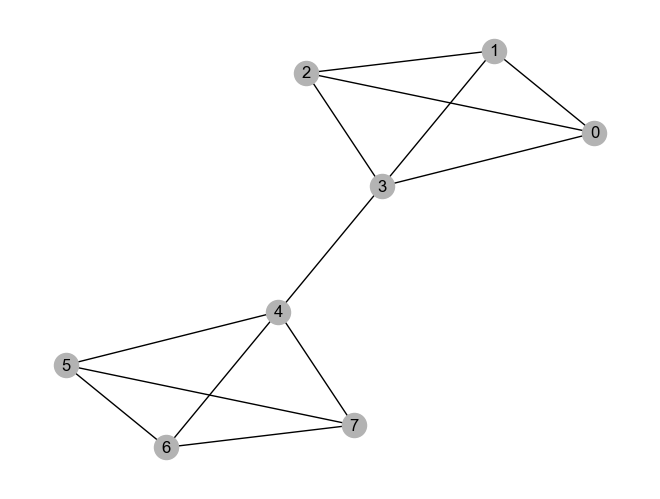

In [157]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Step 3 - Set up optimizer/GNN architecture

In [158]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

# Step 4 - Run GNN training

In [159]:
print('Running GNN...')
gnn_start = time()

input_list_1 = []
probs_list_1 = []
loss_list_1 = []

best_bitstring_list = []
for i in range(10):
    _, epoch, final_bitstring, best_bitstring, input_list_1, probs_list_1, loss_list_1 = run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])
    best_bitstring_list.append(best_bitstring)

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: -0.012342900969088078
Epoch: 1000, Loss: -0.0255188699811697
Stopping early on epoch 1000 (patience: 1000)
GNN training (n=8) took 1.154
GNN final continuous loss: -0.0255188699811697
GNN best continuous loss: -0.0255188699811697
Epoch: 0, Loss: -0.0255188699811697
Epoch: 1000, Loss: -0.06352055817842484
Stopping early on epoch 1000 (patience: 1000)
GNN training (n=8) took 1.04
GNN final continuous loss: -0.06352055817842484
GNN best continuous loss: -0.06352055817842484
Epoch: 0, Loss: -0.06352055817842484
Epoch: 1000, Loss: -0.1347990483045578
Stopping early on epoch 1000 (patience: 1000)
GNN training (n=8) took 1.04
GNN final continuous loss: -0.1347990483045578
GNN best continuous loss: -0.1347990483045578
Epoch: 0, Loss: -0.1347990483045578
Epoch: 1000, Loss: -0.21244767308235168
Stopping early on epoch 1000 (patience: 1000)
GNN training (n=8) took 1.041
GNN final continuous loss: -0.21244767308235168
GNN best continuous loss: -0.21244767308235168
Ep

# Step 5 - Post-process GNN results

In [160]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
for best_bitstring in best_bitstring_list:
    cutVal = postprocess_gnn_max(best_bitstring, nx_graph)
    gnn_tot_time = time() - gnn_start

    print(f'Cut Value: {cutVal}')
    print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1)]
Cut Value: 0.0
Took 172.949s, model training took 35.214s
[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1)]
Cut Value: 0.0
Took 172.95s, model training took 35.214s
[[0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0]] [tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1)]
Cut Value: 1.0
Took 172.95s, model training took 35.214s
[[0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0]] [tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1)]
Cut Value: 1.0
Took 172.951s, model training took 35.214s
[[1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0]] [tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1)]


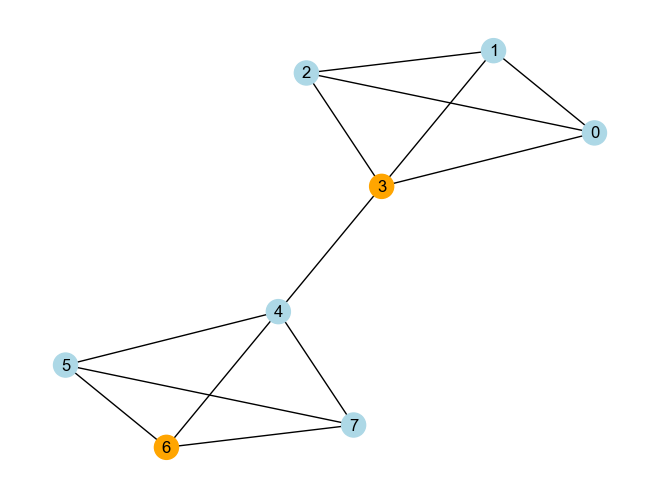

In [162]:
# Visualize result
# Note no light-blue nodes are connected by an edge
color_map = ['orange' if (best_bitstring_list[-1][node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)

# Step 6 - (optional) Compare to classical solver

In [161]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
a,b = run_max_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Max cut found by the heurestics. {a}')
print(f'Max cut paritions. {b}')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=8).
Max cut found by the heurestics. 9
Max cut paritions. ({1, 3, 6, 7}, {0, 2, 4, 5})
MIS solver took 0.001s


# Experiment 2

Using the same graph function, create different graph to test on.
- Different node size, same node degree

In [8]:
# Graph hypers
n = 80
d = 3
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 1000    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 80
seed_value = 1
# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

In [9]:
# Constructs a random d-regular or p-probabilistic graph
nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

Generating d-regular graph with n=80, d=3, seed=1


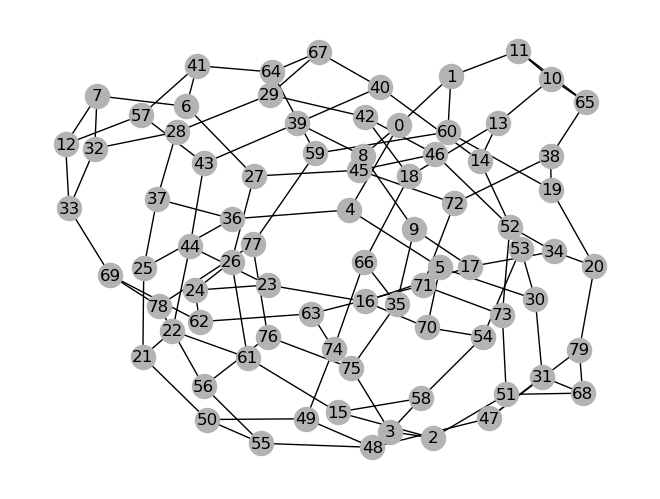

In [10]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [166]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

In [168]:
print('Running GNN...')
gnn_start = time()

input_list_2 = []
probs_list_2 = []
loss_list_2 = []
best_bitstring_list = []

for i in range(5):
    _, epoch, final_bitstring, best_bitstring, input_list_2, probs_list_2, loss_list_2 = run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])
    best_bitstring_list.append(best_bitstring)

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: 101.39513397216797
Epoch: 1000, Loss: 34.09446716308594
Epoch: 2000, Loss: 6.649552822113037
Epoch: 3000, Loss: 0.4424886405467987
Epoch: 4000, Loss: -2.9074597358703613
Epoch: 5000, Loss: -13.503179550170898
Epoch: 6000, Loss: -40.86650466918945
Epoch: 7000, Loss: -59.2351188659668
Epoch: 8000, Loss: -70.44325256347656
Epoch: 9000, Loss: -75.5162124633789
Epoch: 10000, Loss: -78.6502685546875
Epoch: 11000, Loss: -79.51806640625
Epoch: 12000, Loss: -79.77279663085938
Epoch: 13000, Loss: -79.88336944580078
Stopping early on epoch 13115 (patience: 100)
GNN training (n=200) took 43.02
GNN final continuous loss: -79.89167785644531
GNN best continuous loss: -79.89167785644531
Epoch: 0, Loss: -79.89167785644531
Stopping early on epoch 100 (patience: 100)
GNN training (n=200) took 0.131
GNN final continuous loss: -79.8984146118164
GNN best continuous loss: -79.8984146118164
Epoch: 0, Loss: -79.8984146118164
Stopping early on epoch 100 (patience: 100)
GNN trainin

In [169]:
# final_loss = loss_func(final_bitstring.float(), q_torch)
# final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
for best_bitstring in best_bitstring_list:
    cutVal = postprocess_gnn_max(best_bitstring, nx_graph)
    gnn_tot_time = time() - gnn_start

    print(f'Cut Value: {cutVal}')
    print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

[[1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0],

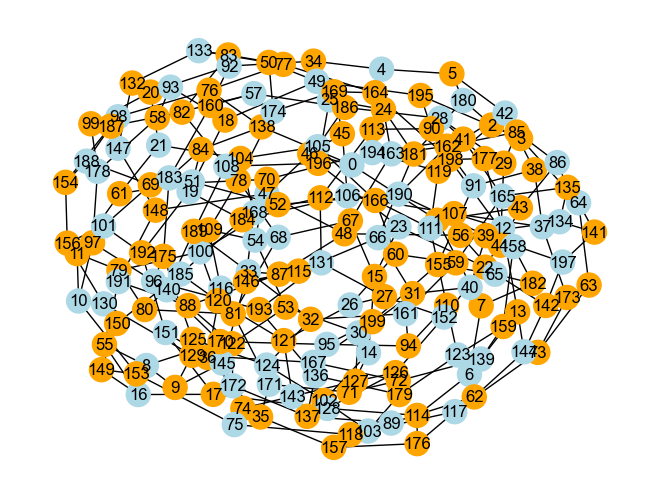

In [170]:
# Visualize result
# Note no light-blue nodes are connected by an edge
color_map = ['orange' if (best_bitstring_list[-1][node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)

In [11]:
# run solver
# run solver
print(f'Running built-in Max solver (n={n}).')
start = time()
a,b = run_max_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Max cut found by the heurestics. {a}')
# print(f'Max cut paritions. {b}')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in Max solver (n=80).
Max cut found by the heurestics. 103
MIS solver took 0.198s


# Experiment 3

Using the same graph function, create different graph to test on.
- Different node size, same node degree, random seed

Generating d-regular graph with n=200, d=6, seed=3


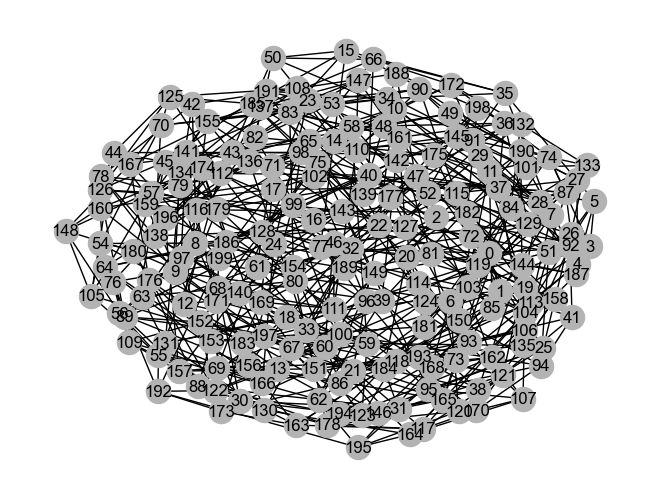

In [175]:
# Graph hypers
n = 200
d = 6
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 1000    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 200
seed_value = 3
# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5
# Constructs a random d-regular or p-probabilistic graph
nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [176]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

print('Running GNN...')
gnn_start = time()

input_list_3 = []
probs_list_3 = []
loss_list_3 = []

best_bitstring_list = []

for i in range(5):
    _, epoch, final_bitstring, best_bitstring, input_list_2, probs_list_2, loss_list_2 = run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])
    best_bitstring_list.append(best_bitstring)

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: 195.32798767089844
Epoch: 1000, Loss: 55.46408462524414
Epoch: 2000, Loss: 8.906229972839355
Epoch: 3000, Loss: 2.1754939556121826
Epoch: 4000, Loss: 0.7561055421829224
Epoch: 5000, Loss: 0.31769901514053345
Epoch: 6000, Loss: 0.14716503024101257
Epoch: 7000, Loss: 0.07219485938549042
Stopping early on epoch 7098 (patience: 1000)
GNN training (n=200) took 10.049
GNN final continuous loss: 0.06750113517045975
GNN best continuous loss: 0.0
Epoch: 0, Loss: 0.06750113517045975
Epoch: 1000, Loss: 0.03460291400551796
Stopping early on epoch 1000 (patience: 1000)
GNN training (n=200) took 1.494
GNN final continuous loss: 0.03460291400551796
GNN best continuous loss: 0.0
Epoch: 0, Loss: 0.03460291400551796
Epoch: 1000, Loss: 0.018206538632512093
Stopping early on epoch 1000 (patience: 1000)
GNN training (n=200) took 1.361
GNN final continuous loss: 0.018206538632512093
GNN best continuous loss: 0.0
Epoch: 0, Loss: 0.018206538632512093
Epoch: 1000, Loss: 0.0096825

[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1],

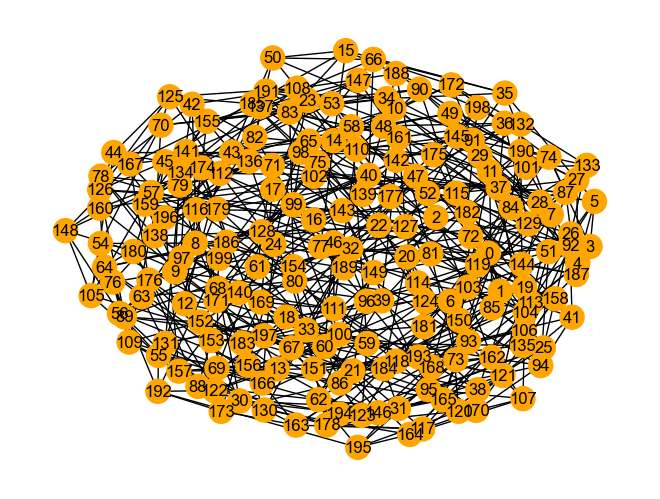

In [178]:
# Process bitstring reported by GNN
for best_bitstring in best_bitstring_list:
    cutVal = postprocess_gnn_max(best_bitstring, nx_graph)
    gnn_tot_time = time() - gnn_start

    print(f'Cut Value: {cutVal}')
    print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

# Visualize result
# Note no light-blue nodes are connected by an edge
color_map = ['orange' if (best_bitstring_list[-1][node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)

In [99]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, nx_number_violations, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {nx_number_violations} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=200).
Calculating violations...
Independence number found by nx solver is 58 with 0 violations.
MIS solver took 1.054s


# Experiment 4

Using the same graph function, create different graph to test on.
- same node size, random node degree, random seed
- multiple graphs for training

Generating d-regular graph with n=200, d=4, seed=3
Generating d-regular graph with n=200, d=3, seed=3
Generating d-regular graph with n=200, d=5, seed=3
Generating d-regular graph with n=200, d=6, seed=3
Generating d-regular graph with n=200, d=3, seed=3
Generating d-regular graph with n=200, d=3, seed=3
Generating d-regular graph with n=200, d=6, seed=3
Generating d-regular graph with n=200, d=3, seed=3
Generating d-regular graph with n=200, d=6, seed=3
Generating d-regular graph with n=200, d=4, seed=3
Generating d-regular graph with n=200, d=3, seed=3
Generating d-regular graph with n=200, d=4, seed=3
Generating d-regular graph with n=200, d=5, seed=3
Generating d-regular graph with n=200, d=6, seed=3
Generating d-regular graph with n=200, d=5, seed=3
Generating d-regular graph with n=200, d=5, seed=3
Generating d-regular graph with n=200, d=6, seed=3
Generating d-regular graph with n=200, d=6, seed=3
Generating d-regular graph with n=200, d=5, seed=3
Generating d-regular graph with

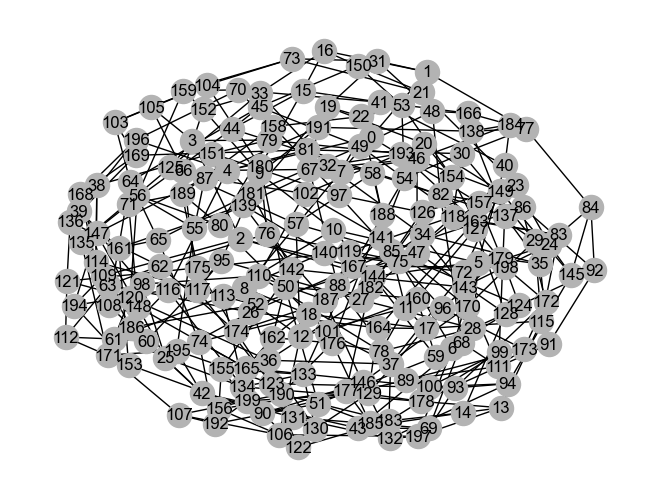

In [179]:
# Graph hypers
n = 100
d = 6
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e4)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 1000    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 200
seed_value = 3
# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

graph_list = {}

for i in range(200):
    d = random_int = random.randint(3, 6)
    seed = random_int = random.randint(1, 100)
    # Constructs a random d-regular or p-probabilistic graph
    nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
    # get DGL graph from networkx graph, load onto device
    graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)

    # Construct Q matrix for graph
    q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    embed = nn.Embedding(n, dim_embedding)
    embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)
    inputs = embed.weight

    graph_list[i] = [nx_graph,graph_dgl, q_torch, inputs]

# Visualize graph
pos = nx.kamada_kawai_layout(graph_list[0][0])
nx.draw(graph_list[0][0], pos, with_labels=True, node_color=[[.7, .7, .7]])

In [180]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

print('Running GNN...')
gnn_start = time()

input_list_4 = []
probs_list_4 = []
loss_list_4 = []

modelNet, epoch, final_bitstring, best_bitstring, input_list_4, probs_list_4, loss_list_4 = run_gnn_training_multigraph(
    graph_list, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: 174.3641815185547
Epoch: 1000, Loss: 112.47726440429688
Epoch: 2000, Loss: 69.99163055419922
Epoch: 3000, Loss: 42.238338470458984
Epoch: 4000, Loss: 25.77657699584961
Epoch: 5000, Loss: 15.608723640441895
Epoch: 6000, Loss: 9.193522453308105
Epoch: 7000, Loss: 5.150966644287109
Epoch: 8000, Loss: 2.6639516353607178
Epoch: 9000, Loss: 1.2818735837936401
GNN training (n=200) took 4377.198
GNN final continuous loss: 0.5178478956222534
GNN best continuous loss: 0.0


In [119]:
# Constructs a random d-regular or p-probabilistic graph
nx_graph = generate_graph(n=200, d=3, p=p, graph_type='reg', random_seed=1)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
embed = nn.Embedding(200, dim_embedding)
embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)
inputs = embed.weight

best_bitstring = modelNet(graph_dgl, inputs)[:, 0]

Generating d-regular graph with n=200, d=3, seed=1


Calculating violations...
Independence number found by GNN is 5.435498237609863 with 0 violations
Took 1175.076s, model training took 1045.107s


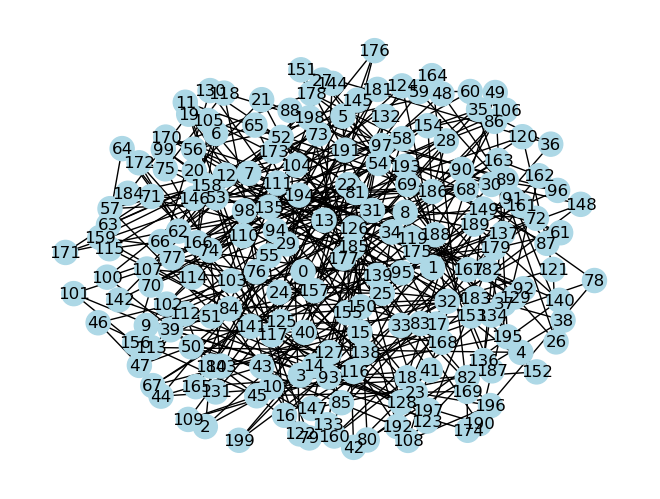

In [120]:
# final_loss = loss_func(final_bitstring.float(), q_torch)
# final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis} with {number_violations} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

# Visualize result
# Note no light-blue nodes are connected by an edge
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)

In [121]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, nx_number_violations, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {nx_number_violations} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=200).
Calculating violations...
Independence number found by nx solver is 77 with 0 violations.
MIS solver took 1.239s


# Analysis for all the inputs, probs and loss

In [122]:
input_list_1

[Parameter containing:
 tensor([[ 1.8653e+00,  1.4996e-01, -6.2979e-01, -1.8332e+00, -1.1978e+00,
           5.6511e-01,  9.2408e-01, -7.4932e-01, -8.5517e-01,  1.4196e+00],
         [ 3.1041e-01,  3.7858e-01, -4.5109e-01,  6.8012e-01,  1.3669e+00,
          -1.8739e+00,  1.3247e-01,  2.9642e-01,  1.1772e+00, -8.5317e-01],
         [-5.4550e-01,  1.2548e+00,  1.2993e+00,  1.1088e+00, -1.8209e+00,
           5.6117e-01,  1.5469e+00,  1.9781e-01,  1.5020e+00, -8.9381e-01],
         [ 1.2086e+00, -1.7999e-01, -4.3571e-01, -8.3924e-01, -1.1146e+00,
           9.5476e-02, -6.9689e-01,  5.4350e-01, -1.5015e+00,  4.7368e-01],
         [ 2.7644e+00,  4.6739e-03,  1.1780e-01,  2.4858e+00, -5.4240e-01,
          -1.3162e+00,  1.7494e+00,  2.8380e-01,  2.0362e+00,  1.4234e+00],
         [-2.9944e-01, -3.1913e+00,  4.5560e-02,  1.5032e+00,  6.3000e-01,
           1.3572e+00, -1.3224e+00, -4.0948e-01, -5.7427e-02, -1.0684e+00],
         [-4.0301e-02, -5.2071e-01, -2.2566e-01,  2.1472e+00, -1.3734e+

In [143]:
print(np.all(np.array(input_list_1[0] == input_list_1[1])))
print(np.all(np.array(input_list_1[0] == input_list_1[4])))
print(np.all(np.array(input_list_1[0] == input_list_1[9])))

print(probs_list_1[0])
print(probs_list_1[4])
print(probs_list_1[9])

True
True
True
tensor([0.4994, 0.4206, 0.5102, 0.4265, 0.4264, 0.5831, 0.4168, 0.7035, 0.5414,
        0.4179, 0.5500, 0.5145, 0.5028, 0.6713, 0.3549, 0.5066, 0.4331, 0.4340,
        0.7411, 0.4460, 0.4440, 0.7209, 0.3425, 0.4569, 0.4459, 0.5121, 0.3894,
        0.3354, 0.5170, 0.5144, 0.4307, 0.5846, 0.4991, 0.4831, 0.5238, 0.4540,
        0.5753, 0.4877, 0.3977, 0.5793, 0.5394, 0.5755, 0.4331, 0.3594, 0.5114,
        0.4871, 0.5572, 0.5912, 0.3968, 0.4822, 0.4455, 0.4560, 0.3849, 0.4249,
        0.6496, 0.3501, 0.4793, 0.4303, 0.4124, 0.4757, 0.3654, 0.4851, 0.4596,
        0.4154, 0.4948, 0.4595, 0.4416, 0.4531, 0.5359, 0.3796, 0.5206, 0.4572,
        0.5585, 0.3436, 0.4322, 0.4340, 0.5365, 0.4620, 0.3810, 0.4750, 0.4572,
        0.4625, 0.5515, 0.5292, 0.4423, 0.4796, 0.4322, 0.4643, 0.4171, 0.2970,
        0.3598, 0.4977, 0.4929, 0.4076, 0.5185, 0.5361, 0.5832, 0.4741, 0.3779,
        0.4618], grad_fn=<SelectBackward0>)
tensor([0.1664, 0.0394, 0.0519, 0.0717, 0.0155, 0.1448, 0.014

In [130]:
print(np.all(np.array(input_list_2[0] == input_list_2[1])))
print(np.all(np.array(input_list_2[0] == input_list_2[4])))
print(np.all(np.array(input_list_2[0] == input_list_2[9])))

True
True
True


In [139]:
print(np.all(np.array(input_list_3[0] == input_list_3[1])))
print(np.all(np.array(input_list_3[0] == input_list_3[4])))
print(np.all(np.array(input_list_3[0] == input_list_3[6])))


True
True
True


In [141]:
print(np.all(np.array(input_list_4[0] == input_list_4[1])))
print(np.all(np.array(input_list_4[0] == input_list_4[4])))
print(np.all(np.array(input_list_4[0] == input_list_4[7])))

True
True
True
